In [121]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pyslaw.transient import HalfPlaneModel, OneLayerModel

# Analytical solution of the flow over a "transient" Witch of Agnesi hill

This notebook shows how to calculate the semi-analytical solution of the uniform, stratified flow over a bell-shaped hill (also known as the Witch of Agnesi). The semi-analytical solution is obtained with PySLAW, which solves linear theory of atmospheric gravity waves.

Created by Dries Allaerts

## Set-up

### Input parameters

Flow parameters: wind speed U and Brunt Vaisala frequency N

In [123]:
U = 10   # Wind speed [m/s]
N = 0.01 # Brunt-Vaisala frequency [1/s]

Hill shape $h\left(x\right) = \large\frac{h_{max}}{1+\left(\frac{x}{L}\right)^2}$


In [124]:
def S(x):
    S = np.zeros(x.shape)
    id = np.where((x>0) & (x<1))
    S[id] = 1/(1+np.exp(1/(x[id]-1)+1/x[id]))
    S[x>=1] = 1
    return S

In [125]:
L = 1000.0   # Characteristic width of the hill [m]
hmax = 100.0 # Height of the hill [m]
tau = 360    # Characteristic time scale [s]

# Shape function of the hill
#hx = lambda x: hmax/(1+(x/L)**2)
hx = lambda x: hmax*np.exp(-(x/L)**2/2)
ht = lambda t: np.exp(-(t/tau)**2/2)
#ht = lambda t: np.ones(t.shape)
#ht = lambda t: S((t+T/8)/tau)-S((t-T/8)/tau+1)

Numerical parameters

In [126]:
Lx = 100.0e3  # Length of the numerical domain [m]
Nx = int(4e2) # Number of grid points

In [127]:
T = 60 * 3600 # Time window [s]
Nt = 3600

Parameters for visualization

In [128]:
Lz = 15.0e3 # Height up to which solution is calculated [m]
Nz = 151    # Number of vertical levels to be used

### Numerical grid

In [129]:
xs,dx = np.linspace(-Lx/2,Lx/2,Nx,endpoint=False,retstep=True)
print('Horizontal grid resolution is {} m'.format(dx))

Horizontal grid resolution is 250.0 m


In [130]:
ts,dt = np.linspace(-T/2,T/2,Nt,endpoint=False,retstep=True)
print('Temporal resolution is {} s'.format(dt))

Temporal resolution is 60.0 s


In [131]:
zs,dz = np.linspace(0,Lz,Nz,retstep=True)
print('Vertical resolution is {} m'.format(dz))

Vertical resolution is 100.0 m


In [132]:
Xs,Ts = np.meshgrid(xs,ts,indexing='ij')

In [133]:
Xs.shape

(400, 3600)

### Model

In [134]:
%time model = HalfPlaneModel(Xs,Ts,hx(Xs)*ht(Ts),U,N)

CPU times: user 278 ms, sys: 50.8 ms, total: 328 ms
Wall time: 341 ms


### Visualize hill

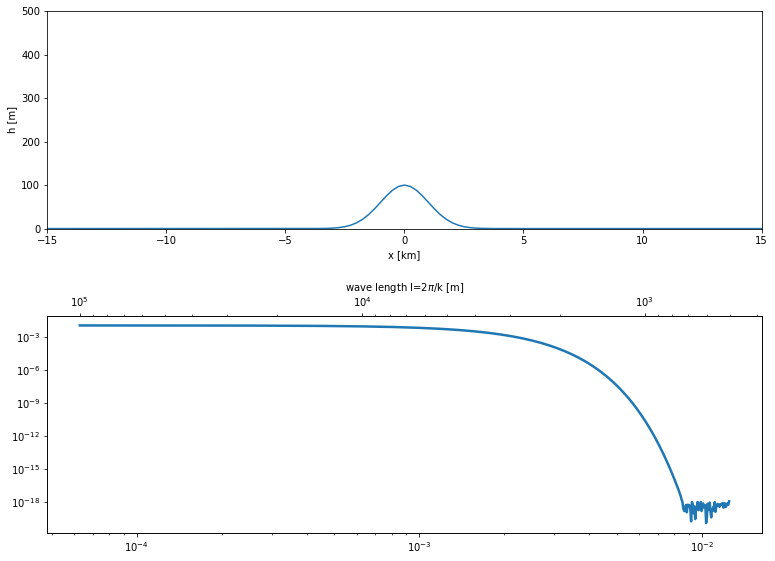

In [135]:
f,ax = plt.subplots(2,1,figsize=(12.8,9.6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(xs/1.e3,hx(xs))
ax[1].loglog(model.k[1:int(Nx/2),0],np.abs(model.hc[1:int(Nx/2),0]),linewidth=2.5,label='FFT')
_ = ax[0].set(xlim=[-15,15],ylim=[0,500],xlabel='x [km]',ylabel='h [m]')
#_ = ax[1].set(xlim=[2e-6,2e-1],ylim=[1e-16,1e2],xlabel=r'wave number k [m$^{-1}$]',ylabel=r'S [m$^2$]')

# Theoretical Fourier transform pair
# In theory, scale factor = pi * L * hmax. However, due to the discrete nature, the scale factor for the
# fft is the integral of h(xs), which approximates pi * L * hmax. As in pyslaw the fft is scaled with Nx
# such that the first mode corresponds to the mean value rather than the sum, the scale is set as
# the mean rather than the integral
#scale = np.mean(h(xs))
#ax[1].loglog(model.k[1:],scale*np.exp(-L*model.k[1:]),'-.k',label='Theory')
#ax[1].axvline(N/U,linestyle=':',label='Scorer parameter')
#ax[1].legend()
ax2 = ax[1].twiny()
ax2.set_xscale('log')
ax2.set_xlabel(r'wave length l=2$\pi$/k [m]')
_ = ax2.set_xlim((2*np.pi/ax[1].get_xlim()[0],2*np.pi/ax[1].get_xlim()[1]))

/Users/dallaerts/opt/anaconda3/envs/py3env/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


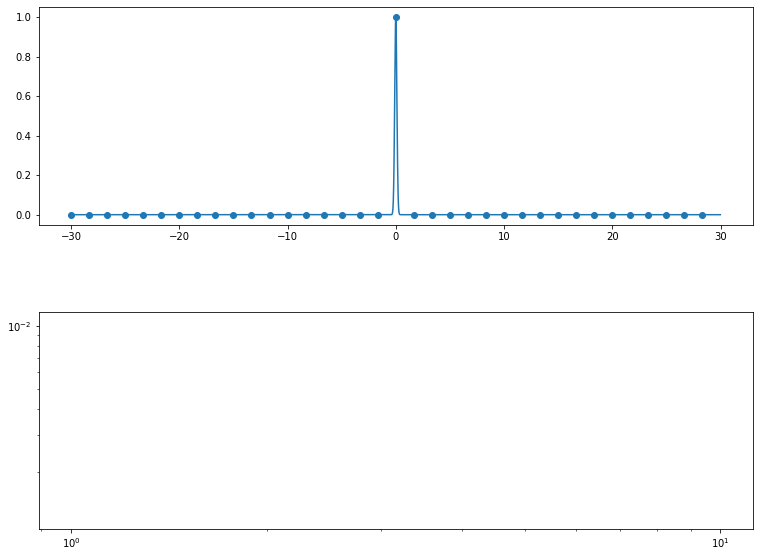

In [136]:
f,ax = plt.subplots(2,1,figsize=(12.8,9.6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(ts/3600,ht(ts),marker='o',markevery=100)
ax[1].loglog(model.omega[0,1:int(Nx/2)],np.abs(model.hc[0,1:int(Nx/2)]),linewidth=2.5,label='FFT')
#_ = ax[0].set(xlim=[-15,15],ylim=[0,500],xlabel='x [km]',ylabel='h [m]')
#_ = ax[1].set(xlim=[2e-6,2e-1],ylim=[1e-16,1e2],xlabel=r'wave number k [m$^{-1}$]',ylabel=r'S [m$^2$]')

## Solve flow problem

In [137]:
%time eta = model.solve('eta',zs)

CPU times: user 12.7 s, sys: 9.52 s, total: 22.2 s
Wall time: 34.1 s


In [138]:
eta.shape

(151, 400, 3600)

In [139]:
%time w = model.solve('w',zs)

CPU times: user 9.33 s, sys: 7.74 s, total: 17.1 s
Wall time: 23.9 s


## Visualization

### Contourplots of vertical displacement $\eta$ and vertical velocity $w$

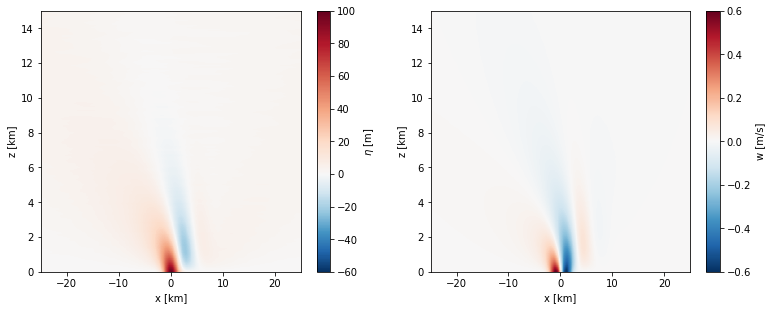

In [142]:
tindex = 1800

f,ax=plt.subplots(1,2,figsize=(12.8,4.8))

# Plot displacement in left axis
im=ax[0].imshow(
             eta[...,tindex],
             #eta[:,tindex,:],
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.,vmin=-60,vmax=100))
cbar = f.colorbar(im,ax=ax[0],shrink=1.0,label=r'$\eta$ [m]')
_ = ax[0].set(xlim=[-25,25],ylim=[0,15],xlabel='x [km]',ylabel='z [km]')

# Plot vertical velocity in right axis
im=ax[1].imshow(
             w[...,tindex],
             #w[:,tindex,:],
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.,vmin=-0.6,vmax=0.6))

# figure mark-up
cbar = f.colorbar(im,ax=ax[1],shrink=1.0,label='w [m/s]')
_ = ax[1].set(xlim=[-25,25],ylim=[0,15],xlabel='x [km]',ylabel='z [km]')

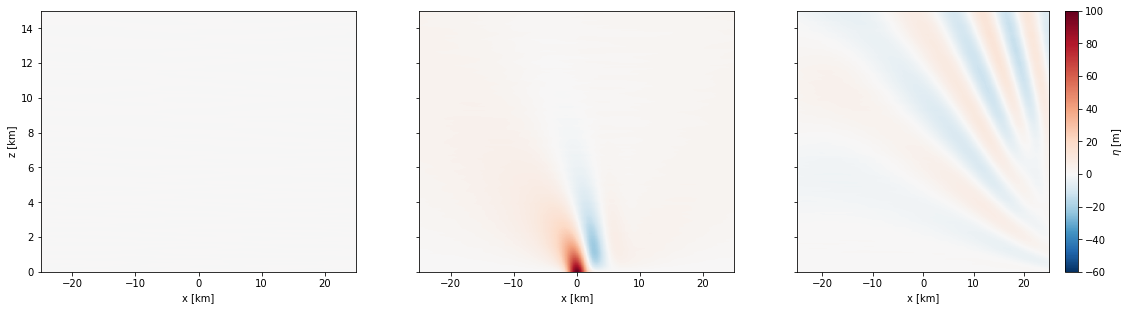

In [143]:
tindices = [1750,1800,1850]#[1200,1400,1500]
f,ax=plt.subplots(1,len(tindices),sharey=True,figsize=(6.4*len(tindices),4.8))

# Plot displacement in left axis
for axi,tindex in enumerate(tindices):
    im=ax[axi].imshow(
             eta[...,tindex],
             #eta[:,tindex,:],
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.,vmin=-60,vmax=100))
    _ = ax[axi].set(xlim=[-25,25],ylim=[0,15],xlabel='x [km]')
cbar = f.colorbar(im,ax=ax[-1],shrink=1.0,label=r'$\eta$ [m]')
_ = ax[0].set(ylabel='z [km]')

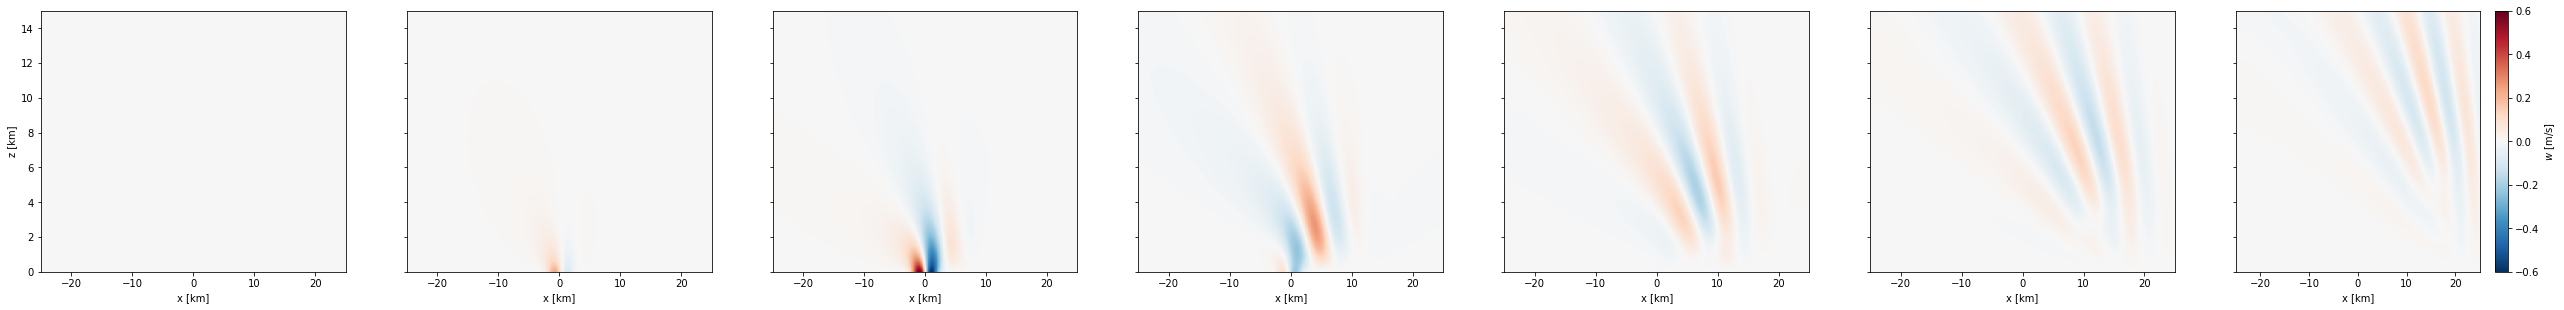

In [146]:
tindices = [1780,1790,1800,1810,1820,1830,1840]
f,ax=plt.subplots(1,len(tindices),sharey=True,figsize=(6.4*len(tindices),4.8))

# Plot displacement in left axis
for axi,tindex in enumerate(tindices):
    im=ax[axi].imshow(
             w[...,tindex],
             #w[:,tindex,:],
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.,vmin=-0.6,vmax=0.6))
    _ = ax[axi].set(xlim=[-25,25],ylim=[0,15],xlabel='x [km]')
cbar = f.colorbar(im,ax=ax[-1],shrink=1.0,label=r'$w$ [m/s]')
_ = ax[0].set(ylabel='z [km]')

In [147]:
from matplotlib import animation, rc
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

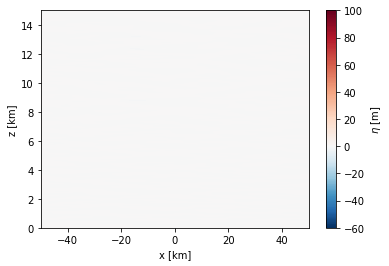

In [152]:
tstart = 1775
frames = range(0,200,5)
f, ax = plt.subplots()
cax = ax.imshow(eta[...,tstart],
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.,vmin=-60,vmax=100))
cbar = f.colorbar(cax,ax=ax,shrink=1.0,label=r'$\eta$ [m]')
_ = ax.set(xlim=[-50,50],ylim=[0,15],xlabel='x [km]',ylabel='z [km]')

def animate(i):
   cax.set_array(eta[...,tstart+i])

anim = animation.FuncAnimation(f, animate, interval=400, frames=frames)

In [153]:
anim